90


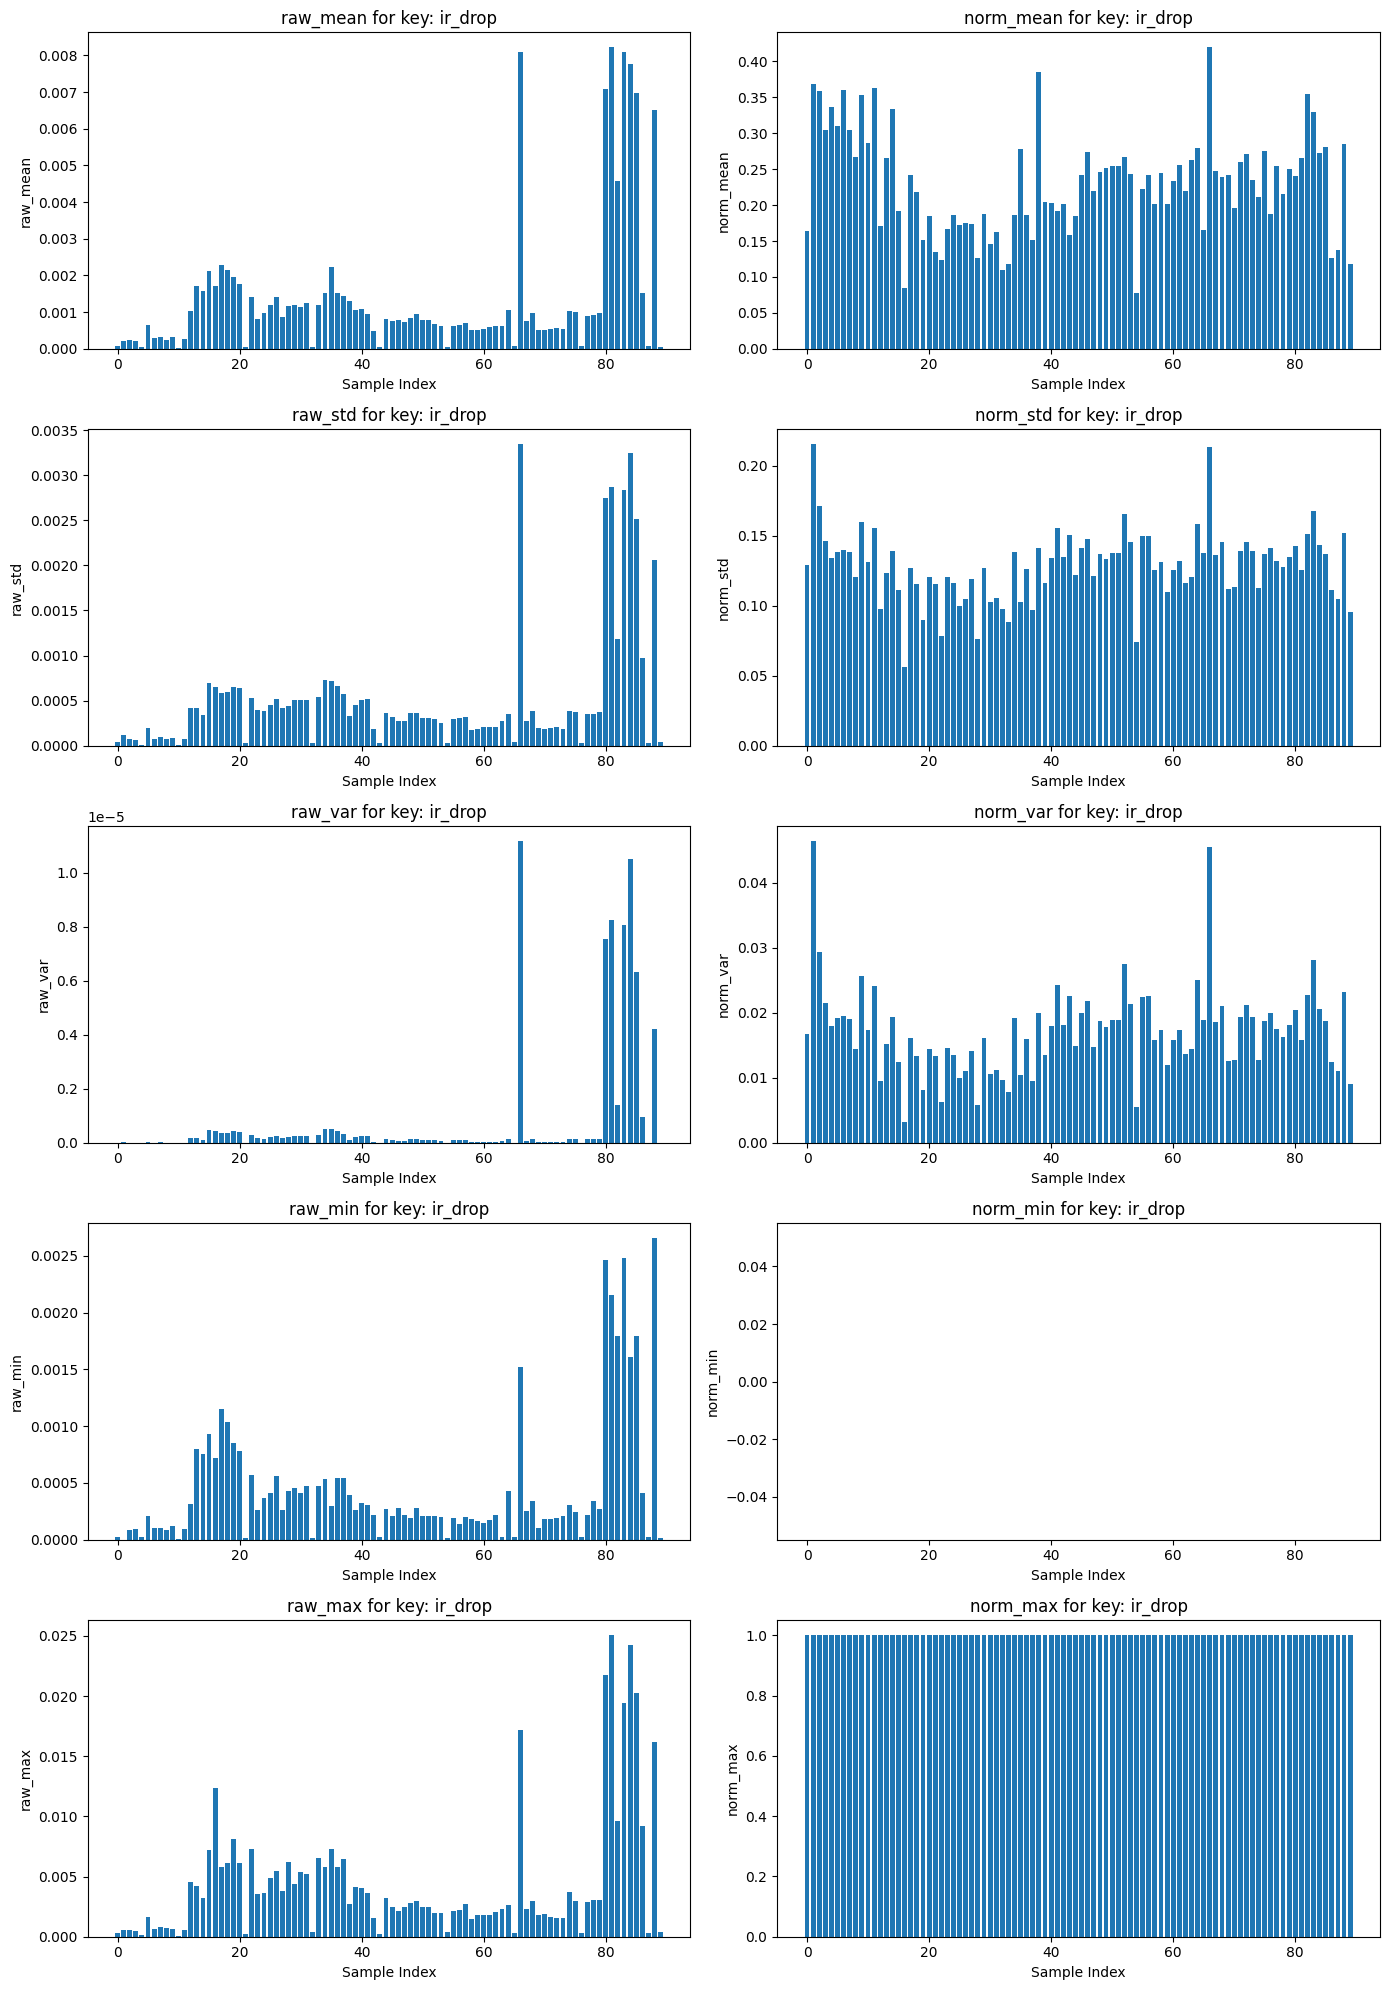

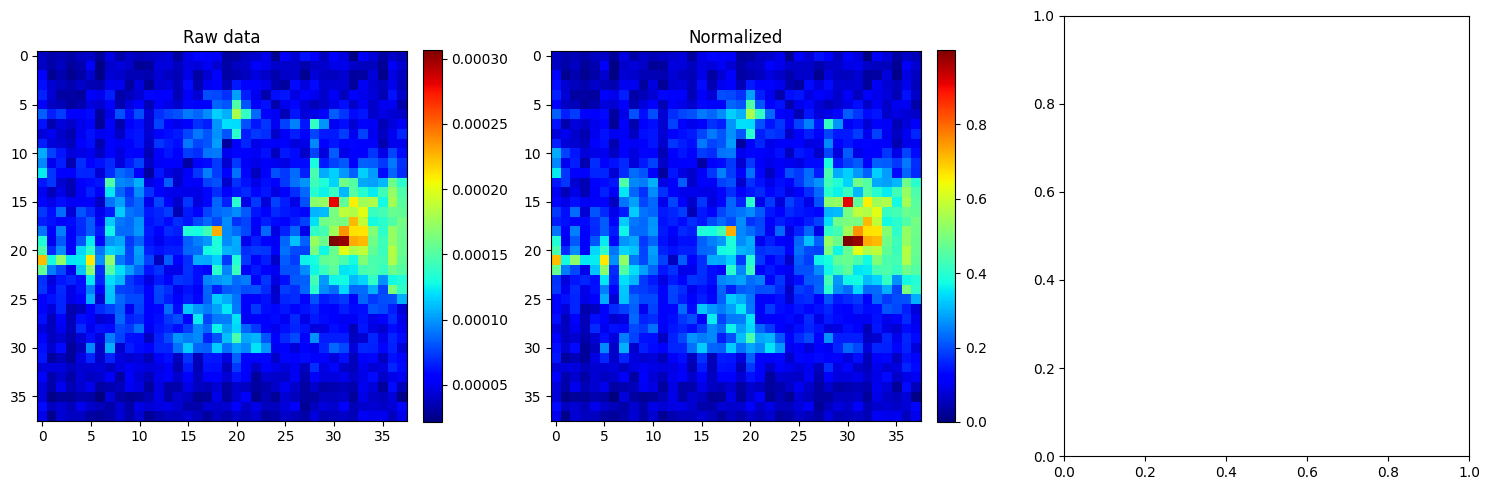

In [21]:
import sys
sys.path.append('../AttnUnet_experiments')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from inference_utils.utils import get_dataset  # 사용 환경에 맞게 import
from config import get_config

# 간단한 Min-Max Normalize 함수 예시
# data 배열을 [0, 1] 범위로 정규화
def min_max_norm(arr: np.ndarray):
    min_val = np.min(arr)
    max_val = np.max(arr)
    # 0으로 나누는 상황 방지를 위해 아주 작은 epsilon 추가
    return (arr - min_val) / (max_val - min_val + 1e-12)

class DatasetStatistics:
    """
    데이터셋의 통계를 계산하고, 정규화 함수(norm_func)를 인자로 받을 수 있도록 확장한 클래스입니다.
    norm_func를 지정하면, 원본 데이터에 대한 통계와 더불어,
    정규화된 데이터에 대한 통계를 함께 비교·시각화합니다.
    """
    def __init__(self, dataset, resize_resolution=None, normalized=False):
        """
        Args:
            dataset: .data_files 속성을 가진 데이터셋 객체.
            resize_resolution, normalized: 여기서는 미사용(예시 코드 그대로 유지).
        """
        self.dataset = dataset

    def _load_sample_data(self, file_info, key, sample_idx):
        """
        file_info 내의 key에 해당하는 파일 혹은 파일 리스트를 로드하여 1차원 배열로 반환합니다.
        값이 문자열 또는 문자열 리스트가 아닌 경우는 건너뜁니다.
        파일이 없거나 에러 발생 시 None을 반환합니다.
        """
        if key not in file_info:
            print(f"Sample {sample_idx}: key '{key}' not found. Skipping.")
            return None

        value = file_info[key]
        if not isinstance(value, (str, list)):
            # 파일 경로가 아닌 값은 건너뜀
            print(f"Sample {sample_idx}: key '{key}' is not a string or list. Skipping.")
            return None

        arr_list = []
        if isinstance(value, list):
            for fpath in value:
                if not os.path.exists(fpath):
                    print(f"Sample {sample_idx}: File {fpath} does not exist. Skipping it.")
                    continue
                try:
                    arr = np.load(fpath)
                    arr_list.append(arr.flatten())
                except Exception as e:
                    print(f"Sample {sample_idx}: Error loading {fpath}: {e}")
            if len(arr_list) == 0:
                return None
            combined = np.concatenate(arr_list)
        else:
            if not os.path.exists(value):
                print(f"Sample {sample_idx}: File {value} does not exist. Skipping sample.")
                return None
            try:
                combined = np.load(value).flatten()
            except Exception as e:
                print(f"Sample {sample_idx}: Error loading {value}: {e}")
                return None

        return combined

    def _load_sample_data_2d(self, file_info, key, sample_idx):
        # 예시: 기존 코드처럼 파일 로드 로직. 여기서는 간단히 np.load로 가정
        # shape가 (h, w), (1, h, w), (h, w, 1) 등 가능
        # 일단 반환은 squeeze() 해서 (h, w) 형태로 맞춰 준다고 가정.
        import os
        if key not in file_info:
            print(f"Sample {sample_idx}: key '{key}' not found. Skipping.")
            return None
        
        value = file_info[key]
        if isinstance(value, str):
            if not os.path.exists(value):
                print(f"Sample {sample_idx}: File {value} does not exist. Skipping sample.")
                return None
            arr = np.load(value)  # shape 예: (256, 256), (1,256,256) ...
            arr = np.squeeze(arr)
            return arr
        else:
            print(f"Sample {sample_idx}: key '{key}' is not a string path. Skipping.")
            return None

    def view_norm_denorm_sample_2d(self, 
                                   key: str, 
                                   sample_idx: int,
                                   norm_func,
                                   denorm_func=None):
        """
        2차원 IR drop map에 대해:
          1) raw data
          2) normalized data
          3) inversed data
        세 가지를 imshow로 subplot에 출력.

        Args:
            key (str): file_info 내부의 키(예: "ir_drop_map")
            sample_idx (int): 몇 번째 샘플인지
            norm_func (callable): 정규화 함수(2D)
            denorm_func (callable): 역정규화 함수(2D)
        """
        if sample_idx < 0 or sample_idx >= len(self.dataset.data_files):
            print(f"Invalid sample_idx {sample_idx}. Out of range.")
            return None

        file_info = self.dataset.data_files[sample_idx]
        data_2d = self._load_sample_data_2d(file_info, key, sample_idx)
        if data_2d is None:
            print(f"No valid data for sample {sample_idx} / key {key}")
            return None
        
        # (1) 원본
        raw_data = data_2d

        # (2) 정규화
        norm_data = norm_func(raw_data)

        # (3) 역정규화
        inv_data = denorm_func(norm_data, raw_data) if denorm_func else None

        # 시각화
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        im0 = axs[0].imshow(raw_data, cmap='jet')
        axs[0].set_title("Raw data")
        plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

        im1 = axs[1].imshow(norm_data, cmap='jet')
        axs[1].set_title("Normalized")
        plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

        if inv_data:
            im2 = axs[2].imshow(inv_data, cmap='jet')
            axs[2].set_title("Denormalized")
            plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

        plt.tight_layout()
        plt.show()

        # return raw_data, norm_data, inv_data
    
    def compute_per_sample_statistics(self, key, norm_func=None):
        """
        각 sample 별로 key에 해당하는 데이터를 로드한 뒤, 
        1) 정규화 전 통계량, 
        2) (norm_func가 주어졌다면) 정규화 후 통계량
        을 계산합니다.

        key가 특정 문자열인 경우 해당 key만, 
        key가 "all"인 경우 file_info 내의 모든 (문자열 또는 문자열 리스트인) 키에 대해 계산합니다.

        통계 결과를 DataFrame으로 반환하며, 
        통계량(평균, 표준편차, 분산, 최소, 최대)에 대해 bar plot도 생성합니다.
        
        Args:
            key (str): 통계량 계산에 사용할 key. 
                       "all"이면 file_info 내 모든 (문자열/문자열 리스트) 키에 대해 반복.
            norm_func (callable): 정규화 함수. 예: min_max_norm

        Returns:
            pd.DataFrame: 통계량을 기록한 DataFrame.
        """
        results = []

        # 통계량을 빠르게 계산하기 위한 헬퍼 함수
        def calc_stats(arr, prefix=""):
            return {
                f"{prefix}mean": np.mean(arr),
                f"{prefix}std": np.std(arr),
                f"{prefix}var": np.var(arr),
                f"{prefix}min": np.min(arr),
                f"{prefix}max": np.max(arr),
            }

        if key != "all":
            # 특정 key에 대해 계산
            for i, file_info in enumerate(self.dataset.data_files):
                data = self._load_sample_data(file_info, key, i)
                if data is None:
                    continue

                # 정규화 전 통계
                raw_stats = calc_stats(data, prefix="raw_")

                # 만약 norm_func가 있으면 정규화 후 통계도 계산
                normed_stats = {}
                normed_data = None
                if norm_func is not None:
                    normed_data = norm_func(data)
                    normed_stats = calc_stats(normed_data, prefix="norm_")

                merged = {
                    "sample_idx": i,
                    "key": key,
                    "file": file_info[key] if isinstance(file_info[key], str) else ", ".join(file_info[key]),
                }
                merged.update(raw_stats)
                merged.update(normed_stats)
                results.append(merged)

            if len(results) == 0:
                print("No valid data found for key:", key)
                return pd.DataFrame()

            df = pd.DataFrame(results)

            # 정규화 전후의 통계량을 각각 bar plot
            # (raw_*, norm_*) 두 종류가 있을 수 있음
            stats_names_raw = ["raw_mean", "raw_std", "raw_var", "raw_min", "raw_max"]
            stats_names_norm = ["norm_mean", "norm_std", "norm_var", "norm_min", "norm_max"]

            # (1) 정규화 전만 있을 경우
            if norm_func is None:
                fig, axs = plt.subplots(len(stats_names_raw), 1, figsize=(10, 4 * len(stats_names_raw)))
                if len(stats_names_raw) == 1:
                    axs = [axs]
                for ax, stat in zip(axs, stats_names_raw):
                    ax.bar(df["sample_idx"], df[stat])
                    ax.set_title(f"{stat} for key: {key}")
                    ax.set_xlabel("Sample Index")
                    ax.set_ylabel(stat)
                plt.tight_layout()
                plt.show()

            else:
                # (2) 정규화 전과 후 모두 있을 경우
                fig, axs = plt.subplots(len(stats_names_raw), 2, figsize=(14, 4 * len(stats_names_raw)))
                # axs는 2차원 배열 (행: 통계량, 열: [raw, norm])
                for row_idx, stat_raw in enumerate(stats_names_raw):
                    stat_norm = stats_names_norm[row_idx]
                    # 왼쪽: raw
                    axs[row_idx, 0].bar(df["sample_idx"], df[stat_raw])
                    axs[row_idx, 0].set_title(f"{stat_raw} for key: {key}")
                    axs[row_idx, 0].set_xlabel("Sample Index")
                    axs[row_idx, 0].set_ylabel(stat_raw)

                    # 오른쪽: norm
                    axs[row_idx, 1].bar(df["sample_idx"], df[stat_norm])
                    axs[row_idx, 1].set_title(f"{stat_norm} for key: {key}")
                    axs[row_idx, 1].set_xlabel("Sample Index")
                    axs[row_idx, 1].set_ylabel(stat_norm)

                plt.tight_layout()
                plt.show()

            return df

        else:
            # key == "all": file_info 내의 모든 (문자열/문자열 리스트) 키에 대해 반복
            for i, file_info in enumerate(self.dataset.data_files):
                for k, value in file_info.items():
                    if not isinstance(value, (str, list)):
                        continue  # 파일 경로가 아닌 경우 건너뜀

                    data = self._load_sample_data(file_info, k, i)
                    if data is None:
                        continue

                    raw_stats = calc_stats(data, prefix="raw_")
                    normed_stats = {}
                    if norm_func is not None:
                        normed_data = norm_func(data)
                        normed_stats = calc_stats(normed_data, prefix="norm_")

                    merged = {
                        "sample_idx": i,
                        "key": k,
                        "file": value if isinstance(value, str) else ", ".join(value),
                    }
                    merged.update(raw_stats)
                    merged.update(normed_stats)
                    results.append(merged)

            if len(results) == 0:
                print("No valid data found for any key.")
                return pd.DataFrame()

            df = pd.DataFrame(results)

            # key별로 따로 그림을 그리고, 정규화 전후 비교
            unique_keys = df["key"].unique()
            for k in unique_keys:
                sub_df = df[df["key"] == k]

                stats_names_raw = ["raw_mean", "raw_std", "raw_var", "raw_min", "raw_max"]
                stats_names_norm = ["norm_mean", "norm_std", "norm_var", "norm_min", "norm_max"]

                if norm_func is None:
                    # 정규화 안 쓸 때
                    fig, axs = plt.subplots(len(stats_names_raw), 1, figsize=(10, 4 * len(stats_names_raw)))
                    if len(stats_names_raw) == 1:
                        axs = [axs]
                    for ax, stat in zip(axs, stats_names_raw):
                        ax.bar(sub_df["sample_idx"], sub_df[stat])
                        ax.set_title(f"{stat} for key: {k}")
                        ax.set_xlabel("Sample Index")
                        ax.set_ylabel(stat)
                    plt.tight_layout()
                    plt.show()

                else:
                    # 정규화 전후 모두
                    fig, axs = plt.subplots(len(stats_names_raw), 2, figsize=(14, 4 * len(stats_names_raw)))
                    for row_idx, stat_raw in enumerate(stats_names_raw):
                        stat_norm = stats_names_norm[row_idx]
                        # 왼쪽 그래프: raw
                        axs[row_idx, 0].bar(sub_df["sample_idx"], sub_df[stat_raw])
                        axs[row_idx, 0].set_title(f"{stat_raw} for key: {k}")
                        axs[row_idx, 0].set_xlabel("Sample Index")
                        axs[row_idx, 0].set_ylabel(stat_raw)

                        # 오른쪽 그래프: norm
                        axs[row_idx, 1].bar(sub_df["sample_idx"], sub_df[stat_norm])
                        axs[row_idx, 1].set_title(f"{stat_norm} for key: {k}")
                        axs[row_idx, 1].set_xlabel("Sample Index")
                        axs[row_idx, 1].set_ylabel(stat_norm)
                    plt.tight_layout()
                    plt.show()

            return df

    def compute_overall_statistics(self, key, norm_func=None):
        """
        데이터셋 전체에 대해 key에 해당하는 데이터를 모아서
        1) 정규화 전 통계량, 
        2) (norm_func가 주어졌다면) 정규화 후 통계량
        을 계산합니다.

        key=="all"이면 file_info 내 모든 키(문자열/문자열 리스트)에 대해 반복.

        Returns:
            - 특정 key (ex: "ir_drop")만 처리하면 dict 형태로 
              {"raw_mean":..., "raw_std":..., ... "norm_mean":..., ...} 반환
            - key=="all"이면 (키별 통계량을 담은) DataFrame 반환
        """
        # 간단한 통계 계산 헬퍼
        def calc_stats(arr, prefix=""):
            return {
                f"{prefix}mean": np.mean(arr),
                f"{prefix}std": np.std(arr),
                f"{prefix}var": np.var(arr),
                f"{prefix}min": np.min(arr),
                f"{prefix}max": np.max(arr),
            }

        if key != "all":
            combined_all = []
            for i, file_info in enumerate(self.dataset.data_files):
                data = self._load_sample_data(file_info, key, i)
                if data is None:
                    continue
                combined_all.append(data)

            if len(combined_all) == 0:
                print("No valid data found for key:", key)
                return None

            # 전체 데이터 한 덩어리로 합침
            overall = np.concatenate(combined_all)

            # 정규화 전 통계
            stats_result = calc_stats(overall, prefix="raw_")

            # 정규화 후 통계(옵션)
            if norm_func is not None:
                normed = norm_func(overall)
                stats_result.update(calc_stats(normed, prefix="norm_"))

            # 시각화: bar plot (정규화 전/후를 각각)
            # 먼저 어떤 키가 있는지 확인
            stats_keys_raw = ["raw_mean", "raw_std", "raw_var", "raw_min", "raw_max"]
            stats_keys_norm = ["norm_mean", "norm_std", "norm_var", "norm_min", "norm_max"]

            if norm_func is None:
                fig, ax = plt.subplots(figsize=(8, 6))
                values = [stats_result[sk] for sk in stats_keys_raw]
                ax.bar(stats_keys_raw, values)
                ax.set_title("Overall Statistics (raw) for key: " + key)
                ax.set_xlabel("Statistic")
                ax.set_ylabel("Value")
                plt.tight_layout()
                plt.show()
            else:
                # 정규화 전후 2개 subplot
                fig, axs = plt.subplots(1, 2, figsize=(14, 5))

                # 왼쪽: raw
                values_raw = [stats_result[sk] for sk in stats_keys_raw]
                axs[0].bar(stats_keys_raw, values_raw)
                axs[0].set_title(f"Overall (raw) Stats for {key}")
                axs[0].set_xlabel("Statistic")
                axs[0].set_ylabel("Value")

                # 오른쪽: norm
                values_norm = [stats_result.get(sk, None) for sk in stats_keys_norm]
                axs[1].bar(stats_keys_norm, values_norm)
                axs[1].set_title(f"Overall (norm) Stats for {key}")
                axs[1].set_xlabel("Statistic")
                axs[1].set_ylabel("Value")

                plt.tight_layout()
                plt.show()

            return stats_result

        else:
            # key == "all": 모든 키에 대해 전체 데이터를 합침
            data_dict = {}  # key -> list of arrays
            for i, file_info in enumerate(self.dataset.data_files):
                for k, value in file_info.items():
                    if not isinstance(value, (str, list)):
                        continue
                    data = self._load_sample_data(file_info, k, i)
                    if data is None:
                        continue
                    if k not in data_dict:
                        data_dict[k] = []
                    data_dict[k].append(data)

            overall_stats = {}
            for k, data_list in data_dict.items():
                overall = np.concatenate(data_list)

                raw_stat = calc_stats(overall, prefix="raw_")
                norm_stat = {}
                if norm_func is not None:
                    normed = norm_func(overall)
                    norm_stat = calc_stats(normed, prefix="norm_")

                # 합쳐서 dict로
                merged = {}
                merged.update(raw_stat)
                merged.update(norm_stat)
                overall_stats[k] = merged

            if len(overall_stats) == 0:
                print("No valid data found for any key.")
                return None

            # bar plot: key별로 raw와 norm을 나눠서 그려보기
            # stats_keys_raw, stats_keys_norm
            stats_keys_raw = ["raw_mean", "raw_std", "raw_var", "raw_min", "raw_max"]
            stats_keys_norm = ["norm_mean", "norm_std", "norm_var", "norm_min", "norm_max"]

            # 전체 key들에 대해 통계량을 그림
            if norm_func is None:
                # 정규화 없이 raw만
                for sk in stats_keys_raw:
                    fig, ax = plt.subplots(figsize=(10, 6))
                    keys = list(overall_stats.keys())
                    values = [overall_stats[k].get(sk, None) for k in keys]
                    ax.bar(keys, values)
                    ax.set_title(f"Overall {sk} for all keys")
                    ax.set_xlabel("Key")
                    ax.set_ylabel(sk)
                    plt.tight_layout()
                    plt.show()
            else:
                # 정규화 전후
                for sk_raw, sk_norm in zip(stats_keys_raw, stats_keys_norm):
                    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

                    # 왼쪽: raw
                    keys = list(overall_stats.keys())
                    values_raw = [overall_stats[k].get(sk_raw, None) for k in keys]
                    axs[0].bar(keys, values_raw)
                    axs[0].set_title(f"(raw) {sk_raw} for all keys")
                    axs[0].set_xlabel("Key")
                    axs[0].set_ylabel(sk_raw)

                    # 오른쪽: norm
                    values_norm = [overall_stats[k].get(sk_norm, None) for k in keys]
                    axs[1].bar(keys, values_norm)
                    axs[1].set_title(f"(norm) {sk_norm} for all keys")
                    axs[1].set_xlabel("Key")
                    axs[1].set_ylabel(sk_norm)

                    plt.tight_layout()
                    plt.show()

            # DataFrame으로 변환
            df_overall = pd.DataFrame.from_dict(overall_stats, orient='index').reset_index()
            df_overall.rename(columns={'index': 'key'}, inplace=True)
            return df_overall

    def compute_statistics(self, key, mode="all", norm_func=None):
        """
        mode 인자에 따라 'per_sample', 'overall', 'all' 중 하나를 수행.
        - 'per_sample': 각 샘플 통계를 계산 (정규화 전/후)
        - 'overall': 전체 통계를 계산 (정규화 전/후)
        - 'all': 둘 다 한꺼번에 수행
        Args:
            key (str): 처리할 key (ex: 'ir_drop'). "all"이면 전부.
            mode (str): 'per_sample', 'overall', 'all'
            norm_func (callable): 정규화 함수. 디폴트 None

        Returns:
            mode='per_sample': pd.DataFrame
            mode='overall': dict 혹은 pd.DataFrame
            mode='all': {'per_sample': ..., 'overall': ...}
        """
        mode = mode.lower()
        if mode == "per_sample":
            return self.compute_per_sample_statistics(key, norm_func=norm_func)
        elif mode == "overall":
            return self.compute_overall_statistics(key, norm_func=norm_func)
        elif mode == "all":
            per_sample = self.compute_per_sample_statistics(key, norm_func=norm_func)
            overall = self.compute_overall_statistics(key, norm_func=norm_func)
            return {"per_sample": per_sample, "overall": overall}
        else:
            print("Unsupported mode. Please choose from 'per_sample', 'overall', or 'all'.")
            return None


# ---------------------------------------------------------
dataset = get_dataset('cus', img_size=256, split='val', use_raw=False, pdn_zeros=True, in_ch=25, types='1um')
stats_calculator = DatasetStatistics(dataset.dataset)
# # 정규화 없이 per_sample 통계
# df_no_norm = stats_calculator.compute_statistics("ir_drop", mode="per_sample", norm_func=None)
# print(df_no_norm)

# min_max_norm 함수 사용 예시
df_with_norm = stats_calculator.compute_statistics("ir_drop", mode="per_sample", norm_func=min_max_norm)
stats_calculator.view_norm_denorm_sample_2d('ir_drop',0,min_max_norm)


In [4]:
get_config('1um').ir_drop.max

0.0250380959999999

90


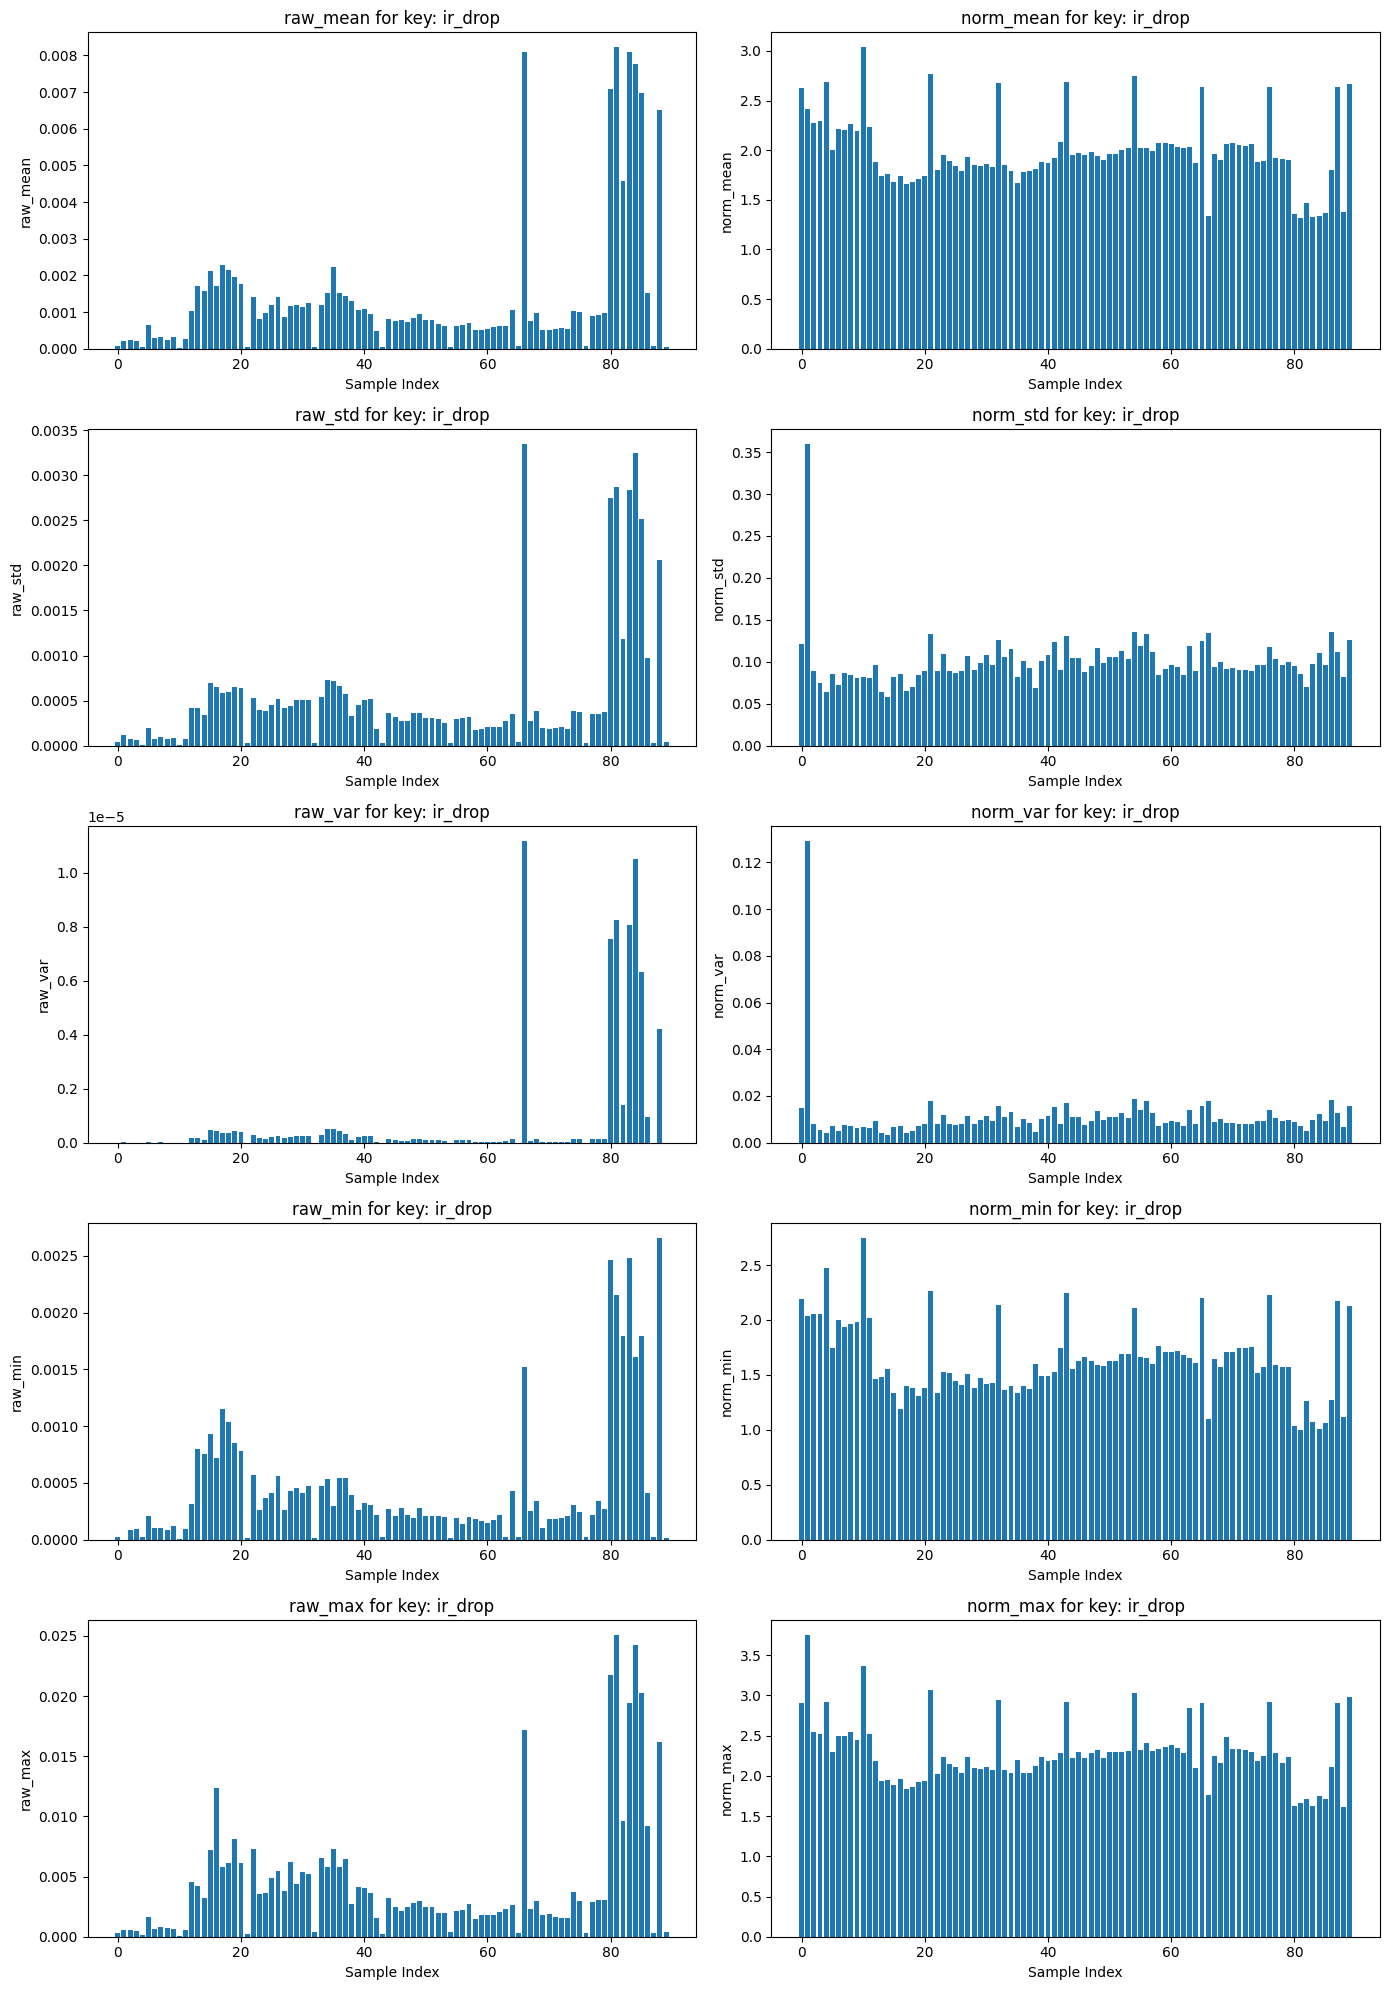

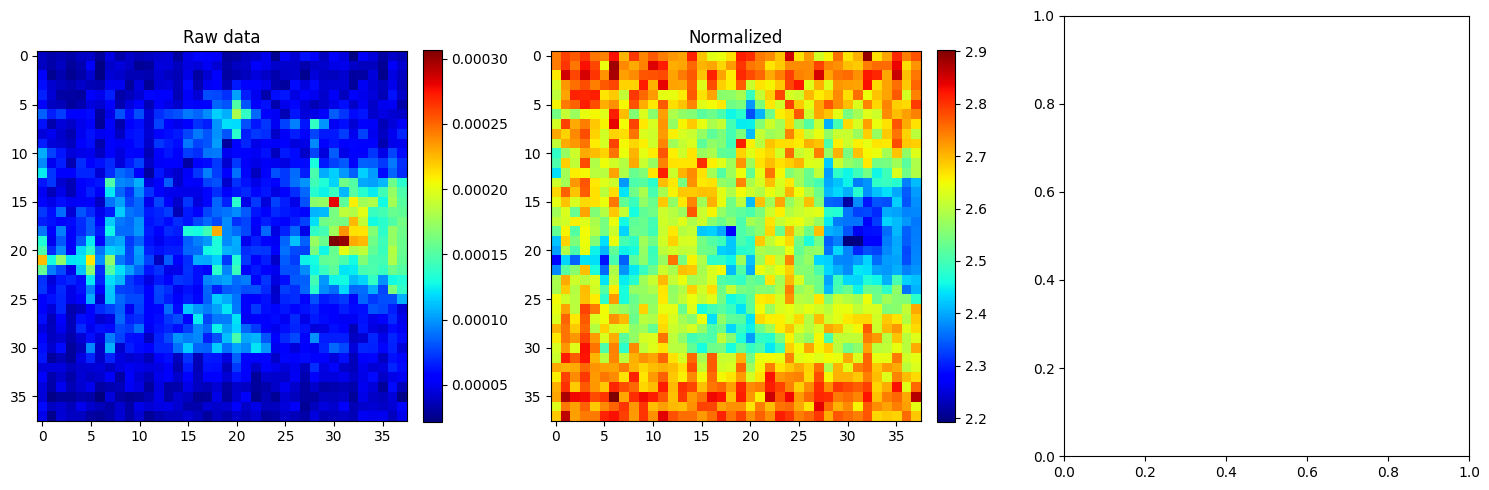

In [20]:

def log_norm(x,global_max,eps=1e-6):
    return np.log(x+eps)/np.log(global_max+eps)

types='1um'

dataset = get_dataset('cus', img_size=256, split='val', use_raw=False, pdn_zeros=True,
                       in_ch=25, types=types)
stats_calculator = DatasetStatistics(dataset.dataset)
df_with_norm = stats_calculator.compute_statistics("ir_drop", mode="per_sample", norm_func=lambda x : log_norm(x,get_config(types).ir_drop.max))
stats_calculator.view_norm_denorm_sample_2d('ir_drop',0,lambda x : log_norm(x,get_config(types).ir_drop.max))

90


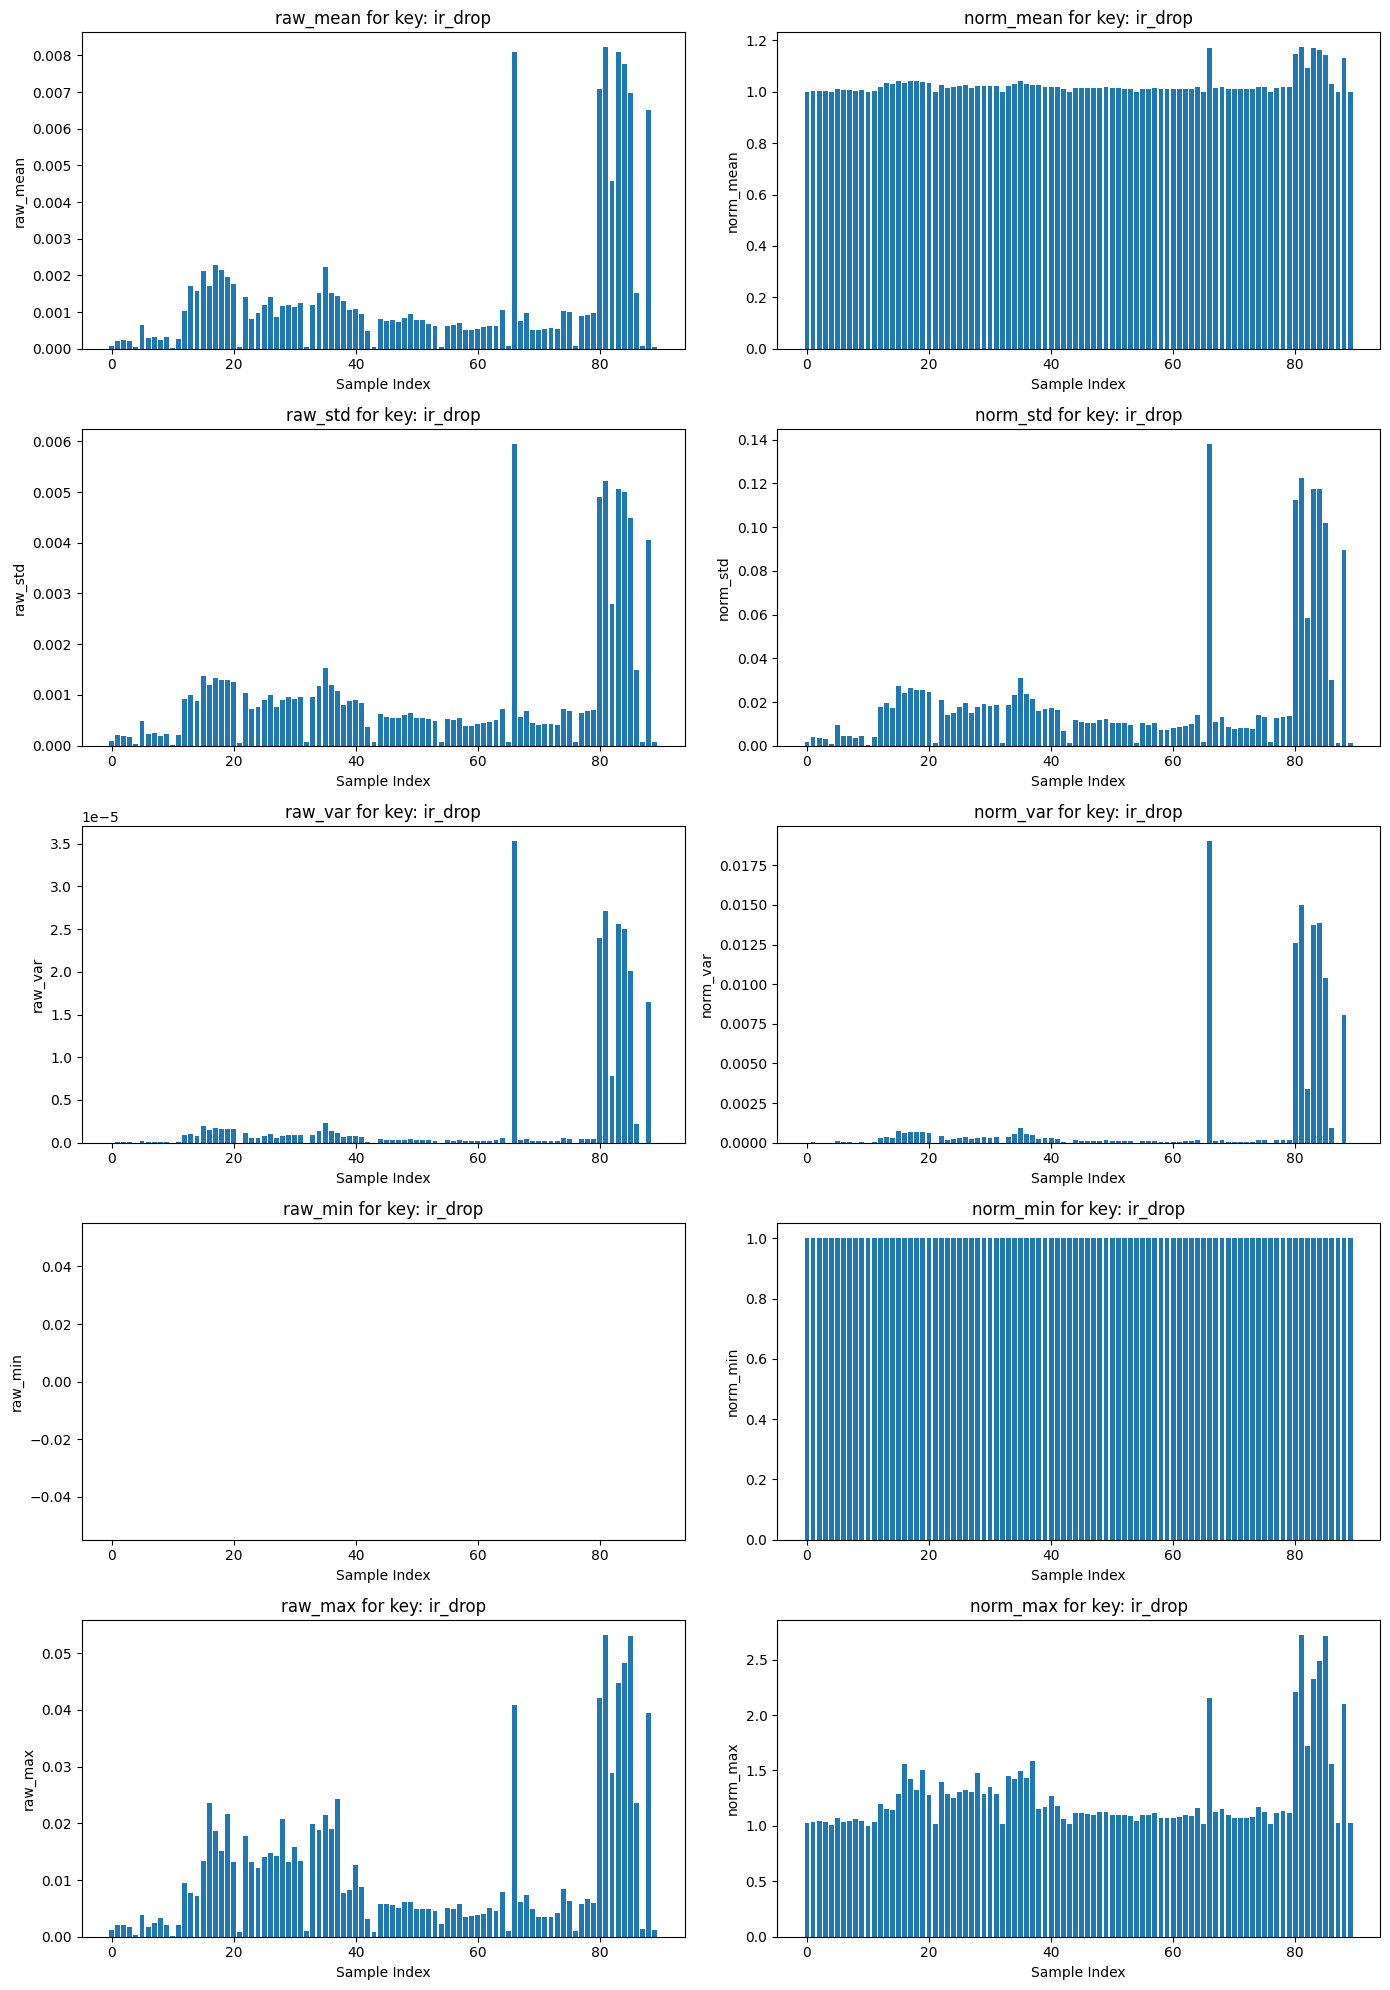

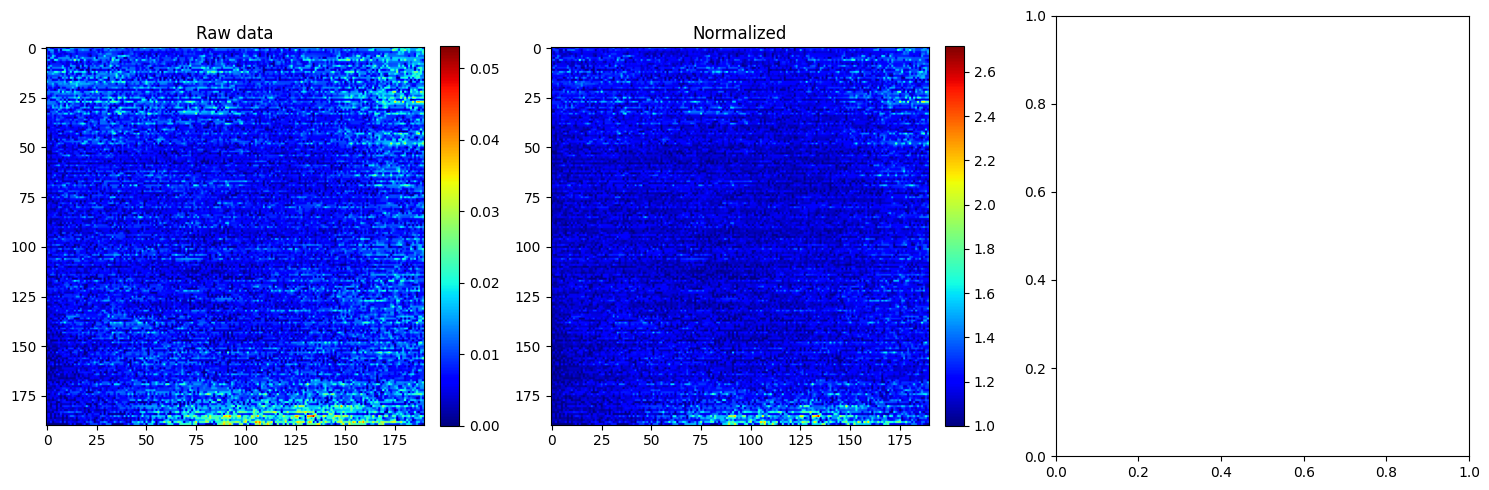

In [25]:
def max_sqrt_norm(x,global_max,eps=1):
    return np.exp(x/global_max)

types='200nm'

dataset = get_dataset('cus', img_size=256, split='val', use_raw=False, pdn_zeros=True,
                       in_ch=25, types=types)
stats_calculator = DatasetStatistics(dataset.dataset)
df_with_norm = stats_calculator.compute_statistics("ir_drop", mode="per_sample", norm_func=lambda x : max_sqrt_norm(x,get_config(types).ir_drop.max))
stats_calculator.view_norm_denorm_sample_2d('ir_drop',81,norm_func=lambda x : max_sqrt_norm(x,get_config(types).ir_drop.max))
